In [77]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import chi2

### ПУНКТ Б)

In [78]:
n = 100
s = 2
m = 10

In [79]:
def gauss(x, m, sigma):
    return 1 / ((2 * np.pi)**0.5 * sigma) * np.e**-((x - m)**2 / (2 * sigma**2))

def ln_gauss(param, x_vals):
    m, sigma = param
    min_ln = 0
    for x in x_vals:
        func = lambda x : gauss(x, m, sigma) 
        integral, _ = integrate.quad(func, x[0], x[1])
        min_ln += np.log(integral ** x[2]) #произведение для функции правдподобия <=> сумма для логарифма функции правдоподобия
    return -min_ln # поиск максимума f(x) <=> поиск минимума -f(x)

Распределение Гаусса принимает максимальное значение в точке, где x = m, так что начальным предположением для m будет 5, т.к. ему соответствует максимальная величина - 18.

Также, из свойств распределения знаем, что на отрезке [m - 2sigma, m + 2sigma] лежит 95% исходов. В нашем случае, 95 исходов из 100 лежат на отрезке [1, 9], а значит предполагаем что сигма = 8 / (2 * 2) = 2

In [80]:
m_teor = 5
sigma_teor = 2

In [81]:
x_vals = [(-np.inf, 1, 5), #[0, 1)
            (1, 2, 8), #[1, 2)
            (2, 3, 6), #[2, 3)
            (3, 4, 12), #[3, 4)
            (4, 5, 14), #[4, 5)
            (5, 6, 18), #[5, 6)
            (6, 7, 11), #[6, 7)
            (7, 8, 6), #[7, 8)
            (8, 9, 13), #[8, 9)
            (9, np.inf, 7) #[9, 0)
           ]

optimized =  minimize(ln_gauss, [m_teor, sigma_teor], args=(x_vals))
m_optimized, sigma_optimized = optimized.x
m_optimized = np.round(m_optimized, 3)
sigma_optimized = np.round(sigma_optimized, 3)
print(f"Значение m по омп: {m_optimized}, \nЗначение sigma по омп {sigma_optimized}")

Значение m по омп: 5.29, 
Значение sigma по омп 2.68


In [82]:
def count_probs(x_vals, m, sigma):  
    probs = []
    func = lambda x : gauss(x, m, sigma) 
    for x in x_vals:
        integral, _ = integrate.quad(func, x[0], x[1])
        probs.append(np.round(integral, 3))
    return probs

In [83]:
p_i = np.array(count_probs(x_vals, m_optimized, sigma_optimized))
np_i = n * p_i

print(p_i)
print(np_i)

[0.055 0.055 0.087 0.119 0.142 0.148 0.134 0.106 0.073 0.083]
[ 5.5  5.5  8.7 11.9 14.2 14.8 13.4 10.6  7.3  8.3]


Все значения n * p_i оказались >= 5, так что ничего не нужно группировать

### Проверка гипотезы по Пирсону

In [84]:
sample_m = np.array([x[2] for x in x_vals])
delta = np.round(np.sum((sample_m - np_i) ** 2 / np_i), 3)
print(f"Оценочное значение дельта: {delta}")

Оценочное значение дельта: 9.796


In [85]:
pirson_p_value = np.round(1 - chi2.cdf(delta, m - 1 - s), 3)
print(f"Значение p-value по Пирсону: {pirson_p_value}")

Значение p-value по Пирсону: 0.2


0.2 > 0.05, так что нет оснований отвергать гипотезу Н0 по Пирсону

### Проверка гипотезы по Колмогорову

Δ по Колмогорову: 1.01


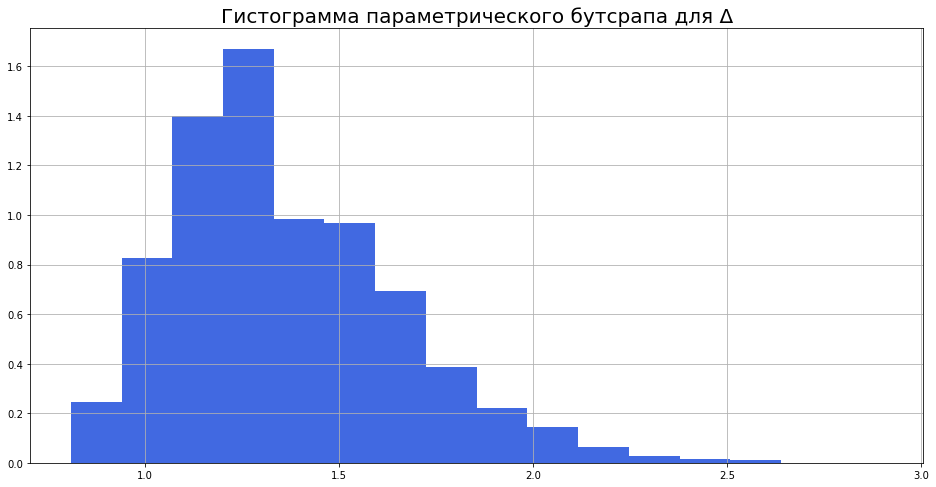

In [86]:
def hystogramma(x : list[float]) -> None:
    n = int(1 + np.log2(len(x)))  
    plt.figure(figsize = (16, 8))
    plt.grid()
    plt.hist(x, bins=n, density=True, color = "royalblue")
    plt.title('Гистограмма параметрического бутсрапа для Δ', fontsize=20)
    plt.show()

def count_delta(probs, x, n = 100):
    delta = 0
    vals = [0]
    for i in range(1, 11):
        vals.append(len(x[x < i]))
    
    for i in range(1, 11):
        delta = max(delta, abs(probs[i - 1] - vals[i - 1]/n), abs(probs[i - 1] - vals[i]/n))
    return delta * (n ** 0.5)

def param_bootstrap(m, sigma, sample):
    deltas = np.array([])
    
    x_vals = np.arange(10)
    probs = []   
    func = lambda x : gauss(x, m, sigma) 
    for x in x_vals:
        probs.append(np.round(integrate.quad(func, -np.inf, x)[0], 3))
    
    x_delta = []
    for i in range(10): x_delta += [i] * sample[i]
    delta = count_delta(probs, np.array(x_delta))
    print(f"Δ по Колмогорову: {np.round(delta, 3)}")
    
    for _ in range (50000):
        i_subsample = np.round(np.random.normal(m, sigma, 100)) % 10
        
        i_delta = count_delta(probs, i_subsample)
        deltas = np.append(deltas, i_delta)
    
    hystogramma(deltas)
    
    return len(deltas[deltas > delta]) / 50000

x_delta = []
for i in range(10):
    x_delta += [i] * sample_m[i]
x_selta = np.array(x_delta)
col_sigma = (np.std(x_delta)) ** 0.5
col_m = np.mean(x_delta)
kolm_boot_p_value = param_bootstrap(col_m, col_sigma ** 2, sample_m)

In [87]:
print(f"Значение p-value по Колмогорову с параметрическим бутстрапом: {kolm_boot_p_value}")

Значение p-value по Колмогорову с параметрическим бутстрапом: 0.91368


Значение p-value с по Колмогорову ~ 0.9

0.9 > 0.05, так что нет оснований отвергать Н0 по Колмогорову с бутстрапом

#### Вывод: нет оснований отвергать гипотезу Н0 что по Пирсону, что по Колмогорову